In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [10]:
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# get last date from file
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
# convert last date into dt item
last_date_dt = pd.to_datetime(last_date)
# last_date_dt

In [14]:
# calculate the date 1 year ago from the last date in the database
year_ago = last_date_dt - dt.timedelta(days=365)

# convert year ago to a string
year_ago_str = year_ago.strftime("%Y-%m-%d")[0]
year_ago_str

'2016-08-23'

In [15]:
# Perform a query to retrieve the data and precipitation scores
yearly_precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago_str).all()
# yearly_precipitation

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(yearly_precipitation).set_index("date").sort_index(ascending=True)
prcp_df = prcp_df.rename(columns={"prcp":"Precipitation"})
prcp_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


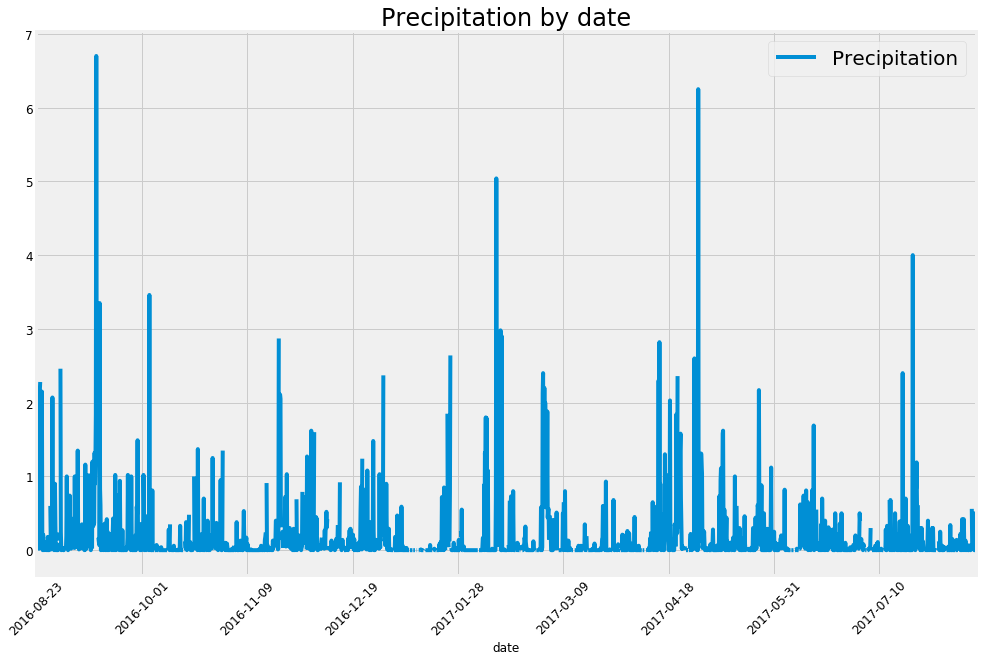

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(15,10))
plt.title("Precipitation by date",fontsize=24)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=20)

plt.savefig("my_images/prcp_by_date.png")

plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary_dict = {
    "count":prcp_df.count(),
    "mean":prcp_df.mean(),
    "std":prcp_df.std(),
    "min":prcp_df.mean(),
    "25%":prcp_df.quantile(.25),
    "50%":prcp_df.quantile(.5),
    "75%":prcp_df.quantile(.75),
    "max":prcp_df.max()
}

prcp_summary_df = pd.DataFrame.from_dict(prcp_summary_dict).T
prcp_summary_df = prcp_summary_df.rename(columns={"Precipitation":"Precipitation Stats"})
prcp_summary_df

,Precipitation Stats
count,2021.000000
mean,0.177279
std,0.461190
min,0.177279
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Station.station).count()
stations_available

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, Station.name, func.count(Measurement.date)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
active_stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [21]:
# store top station data
top_station_id = active_stations[0][0]
top_station_name = active_stations[0][1]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [ 
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]

temperature_stats = session.query(*sel).\
    filter(Measurement.station == top_station_id).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observed = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == top_station_id).\
    filter(Measurement.date >= year_ago_str).\
    all()
# temp_observed

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
top_station_temp_df = pd.DataFrame(temp_observed)
top_station_temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


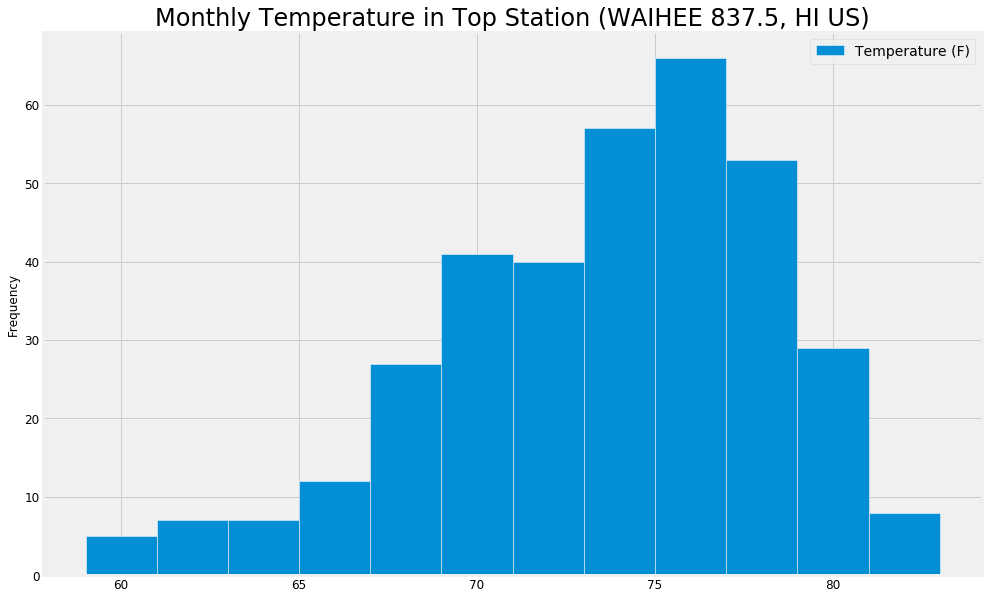

In [25]:
# plot monthly temperature as a histogram
top_station_temp_df["tobs"].hist(figsize=(15,10),bins=12,label="Temperature (F)",edgecolor='w')
plt.title("Monthly Temperature in Top Station ({})".format(top_station_name),fontsize=24)
plt.ylabel("Frequency")
plt.legend(loc="upper right",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("my_images/monthly_temp_top_station.png")

plt.show()

In [26]:
# Optional Section

In [27]:
# store trip start and end dates for later use
start_date = '2017-05-22'
end_date ='2017-05-30'

In [28]:
# Fuction to calculate avg, min, max of temperature, given dates as input 
def calc_temps(start_date, end_date):
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    qry = session.query(*sel).\
        group_by(Measurement.date).\
        filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
        filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).\
        all()

    return qry 

In [29]:
# Using previous function `calc_temps` to calculate the tmin, tavg, and tmax for my trip
dates_temp = calc_temps('2016-05-22', '2016-05-30')
dates_temp

[('2016-05-22', 75.0, 77.2, 79.0),
 ('2016-05-23', 73.0, 76.85714285714286, 79.0),
 ('2016-05-24', 67.0, 73.28571428571429, 78.0),
 ('2016-05-25', 69.0, 74.57142857142857, 78.0),
 ('2016-05-26', 71.0, 75.85714285714286, 81.0),
 ('2016-05-27', 75.0, 77.8, 80.0),
 ('2016-05-28', 72.0, 76.2, 79.0),
 ('2016-05-29', 71.0, 74.8, 78.0),
 ('2016-05-30', 70.0, 72.83333333333333, 78.0)]

In [30]:
# create df of dates_temp data
dates_temp_df = pd.DataFrame(dates_temp, columns=["date", "tmin", "tavg", "tmax"])
dates_temp_df = dates_temp_df.set_index('date', drop=True)
dates_temp_df.head()

,tmin,tavg,tmax
date,,,
2016-05-22,75.0,77.200000,79.0
2016-05-23,73.0,76.857143,79.0
2016-05-24,67.0,73.285714,78.0
2016-05-25,69.0,74.571429,78.0
2016-05-26,71.0,75.857143,81.0


In [31]:
# store avg, min, max from the same days in the past year
dates_temp_days = dates_temp_df.index.values
dates_temp = dates_temp_df['tavg']
# dates_temp = dates_temp_df['tmin']
# dates_temp = dates_temp_df['tmax']

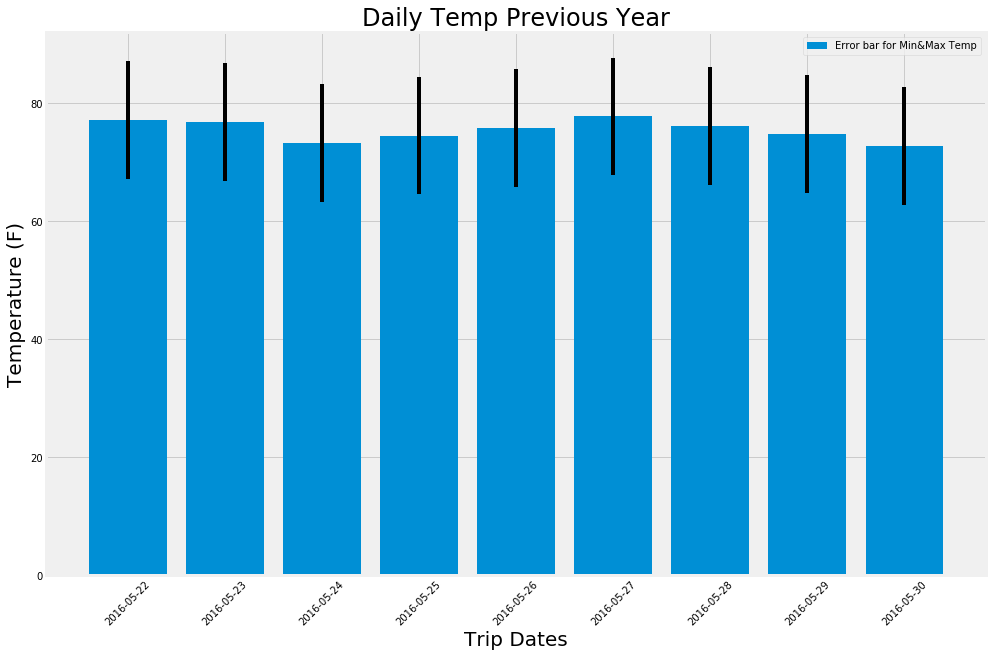

In [32]:
# plot the avg, min, max from the same days in the past year 
plt.figure(figsize=[15, 10])
plt.bar(dates_temp_days,dates_temp,yerr=10,label='Error bar for Min&Max Temp')
plt.title("Daily Temp Previous Year",fontsize=24)
plt.ylabel("Temperature (F)",fontsize=20)
plt.xlabel("Trip Dates",fontsize=20)
plt.xticks(rotation=45)
plt.legend()

plt.savefig("my_images/daily_temp_previous_year.png")

plt.show()

In [33]:
# store average of the whole period
dates_temp_avg = dates_temp_df['tavg'].mean()

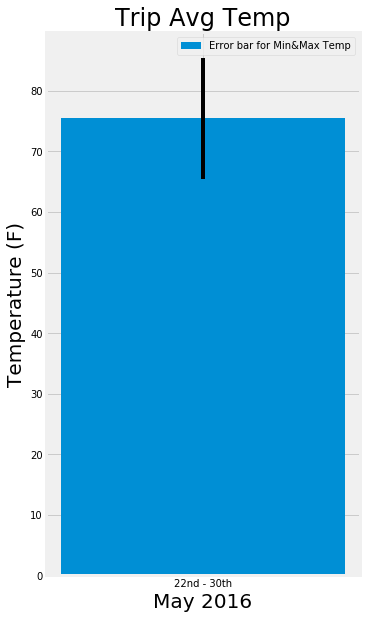

In [34]:
#Plot the total Avg Temp for My Trip
plt.figure(figsize=[5, 10])
plt.bar("22nd - 30th", dates_temp_avg, yerr=10, label='Error bar for Min&Max Temp')
plt.ylabel('Temperature (F)', fontsize=20)
plt.xlabel("May 2016",fontsize=20)
plt.title('Trip Avg Temp', fontsize=24)
plt.legend()

plt.savefig("my_images/avg_temp_previous_year.png")

plt.show()

In [35]:
# calculate the total amount of rainfall per weather station for your trip dates using the previous year's dates
# sort this in descending order by precipitation 
sels = [
    Measurement.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.avg(Measurement.prcp)
]

rainfall_per_station = session.query(*sels).\
    group_by(Measurement.station).\
    order_by(func.avg(Measurement.prcp).desc()).\
    filter(Measurement.date >= "2016-05-22").\
    filter(Measurement.date >= "2016-05-30").\
    all()
rainfall_per_station

[('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.5095959595959528),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.2430892448512561),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.1648130841121478),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.1278005115089515),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.12365030674846554),
 ('USC00517948',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.08054794520547934),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.05416666666666697)]

In [36]:
# function to calculate the daily normals 

def daily_normals(date):
    sel = [
        func.strftime("%m-%d", Measurement.date),
        func.min(Measurement.tobs), 
        func.avg(Measurement.tobs), 
        func.max(Measurement.tobs)
    ]
    
    qry = session.query(*sel).\
        filter(func.strftime("%m-%d", Measurement.date) == date).\
        all()
    
    return qry

In [37]:

# trip dates range
dates = session.query(Measurement.date).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).all()

# List of dates
trip_dates = [date for date in dates]

# list of dates without year (%m-%d) 
trip_dates_mm_dd = [date[0][5:] for date in trip_dates]


# Find the start month/day and the end month/day 
start_month_day = trip_dates_mm_dd[0]
end_month_day = trip_dates_mm_dd[-1]

In [38]:
# create list of %m-%d dates
trip_normals = []
for date in trip_dates_mm_dd:
    trip_normals.append(daily_normals(date))
    
trip_normals = [list(x) for x in zip(*trip_normals)]
trip_normals = trip_normals[0]

In [39]:
normals_df = pd.DataFrame(trip_normals, columns=["date","tmin", "tavg", "tmax"])
normals_df = normals_df.set_index("date")
normals_df

,tmin,tavg,tmax
date,,,
05-22,64.0,74.456140,80.0
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0
05-27,65.0,74.490909,80.0
05-28,67.0,74.277778,82.0
05-29,64.0,74.196078,80.0
05-30,69.0,74.333333,81.0


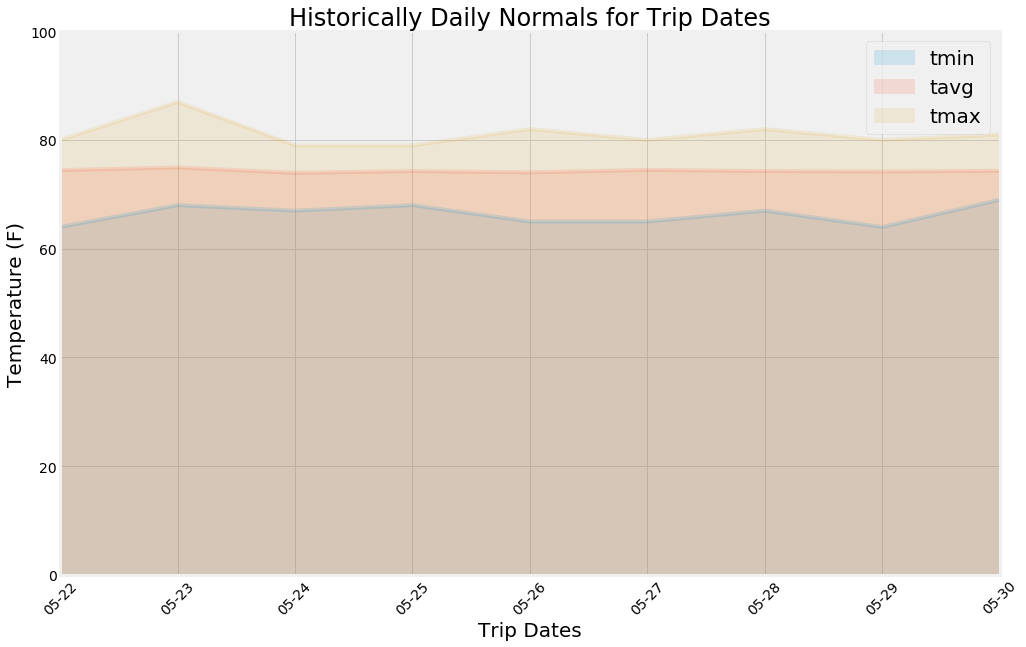

In [40]:
# plot daily normals, min, and max for trip dates historically
normals_df.plot(kind='area', alpha=.15,x_compat=True, stacked=False, figsize=(15,10))
plt.title("Historically Daily Normals for Trip Dates",fontsize=24)
plt.ylabel("Temperature (F)",fontsize=20)
plt.xlabel("Trip Dates",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,100)
plt.xticks(rotation=45)
plt.legend(fontsize=20)

plt.savefig("my_images/historically_daily_normals.png")

plt.show()
